In [1]:
from train_utils import *
import torch
from torch.utils.data import DataLoader
from dataset.dataset_loader import SNDataset,SNDatasetClimate, myNormalize, myToTensor, Augmentations
from torchvision import transforms
import random
import numpy as np
from dataset.utils.utils import TextColors as tc
from plot_utils.plot import plot_train_test_losses
from datetime import date, datetime
import torch.nn.functional as F
import cv2
import json

In [2]:
# create a folder called 'results' in the current directory if it doesn't exist
if not os.path.exists('results'):
    os.mkdir('results')

In [3]:
# Format the date and time
now = datetime.now()
start_string = now.strftime("%Y-%m-%d %H:%M:%S")
print("Current Date and Time:", start_string)

Current Date and Time: 2023-06-05 10:13:42


In [4]:
import os
os.getcwd()

NAFISEH = "Nafiseh"
MOIEN = "Moien"

if "d:" in os.getcwd():
    USER = MOIEN
elif "c:" in os.getcwd():
    USER = NAFISEH
else:
    raise Exception("Unknown user")

USER

'Nafiseh'

In [5]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
# CONFIG
NUM_WORKERS = 6 if USER == NAFISEH else 2
TRAIN_BATCH_SIZE = 32 if USER == NAFISEH else 4
TEST_BATCH_SIZE = 32 if USER == NAFISEH else 4
LEARNING_RATE = 1e-4 if USER == NAFISEH else 1e-4
NUM_EPOCHS = 30 if USER == NAFISEH else 2
LR_SCHEDULER = "step" # step, plateau or None

OC_MAX = 87
USE_SRTM = True

USE_SPATIAL_ATTENTION = True if USER == NAFISEH else True
RESNET_VERSION = 'v1' # v1 or v2
REG_VERSION = 1 if USER == NAFISEH else 2
USE_LSTM_BRANCH = False

In [7]:

if USE_SRTM:
    mynorm = myNormalize(img_bands_min_max =[[(0,7),(0,1)], [(7,12),(-1,1)], [(12), (-4,2963)], [(13), (0, 90)]], oc_min = 0, oc_max = OC_MAX)
else:
    mynorm = myNormalize(img_bands_min_max =[[(0,7),(0,1)], [(7,12),(-1,1)]], oc_min = 0, oc_max = OC_MAX)
    
my_to_tensor = myToTensor()
my_augmentation = Augmentations()
train_transform = transforms.Compose([mynorm, my_to_tensor,my_augmentation])
test_transform = transforms.Compose([mynorm, my_to_tensor])

In [8]:
if USER == MOIEN:
    train_l8_folder_path = 'D:\python\SoilNet\dataset\l8_images\\train\\'
    test_l8_folder_path = 'D:\python\SoilNet\dataset\l8_images\\test\\'
    val_l8_folder_path = 'D:\python\SoilNet\dataset\l8_images\\val\\'
    lucas_csv_path = 'D:\python\SoilNet\dataset\LUCAS_2015_all.csv'
    climate_csv_folder_path = "D:\\python\\SoilNet\\dataset\\Climate\\All\\filled\\"
    
elif USER == NAFISEH:
    train_l8_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-3\\SoilNet\\dataset\\l8_images_87\\train'
    test_l8_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-3\\SoilNet\\dataset\\l8_images_87\\test'
    val_l8_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-3\\SoilNet\\dataset\\l8_images_87\\val'
    testval_l8_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-3\\SoilNet\\dataset\\l8_images_87\\test_val'
    lucas_csv_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-3\\SoilNet\\dataset\\LUCAS_2015_all.csv'
    climate_csv_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-3\\SoilNet\\dataset\\Climate\\All\\filled'

In [9]:
bands = [0,1,2,3,4,5,6,7,8,9,10,11] if not USE_SRTM else [0,1,2,3,4,5,6,7,8,9,10,11,12,13]


################################# IF Not USE_LSTM_BRANCH ###############################
if not USE_LSTM_BRANCH: # NOT USING THE CLIMATE DATA

    train_ds = SNDataset(train_l8_folder_path, lucas_csv_path,l8_bands=bands, transform=train_transform)
    test_ds =  SNDataset(test_l8_folder_path, lucas_csv_path,l8_bands=bands, transform=test_transform)
    val_ds = SNDataset(val_l8_folder_path, lucas_csv_path,l8_bands=bands, transform=test_transform)
    test_ds_w_id =  SNDataset(test_l8_folder_path, lucas_csv_path,l8_bands=bands, transform=test_transform, return_point_id=True)
    testval_ds_w_id =  SNDataset(testval_l8_folder_path, lucas_csv_path,l8_bands=bands, transform=test_transform, return_point_id=True)
    
################################### IF USE_LSTM_BRANCH #################################
else: # USING THE CLIMATE DATA
    train_ds = SNDatasetClimate(train_l8_folder_path,
                                    lucas_csv_path,
                                    climate_csv_folder_path,
                                    l8_bands=bands, transform=train_transform)

    test_ds = SNDatasetClimate(test_l8_folder_path,
                                lucas_csv_path,
                                climate_csv_folder_path,
                                l8_bands=bands, transform=test_transform)
    
    val_ds = SNDatasetClimate(val_l8_folder_path,
                                lucas_csv_path,
                                climate_csv_folder_path,
                                l8_bands=bands, transform=test_transform)
    
    test_ds_w_id = SNDatasetClimate(test_l8_folder_path,
                                lucas_csv_path,
                                climate_csv_folder_path,
                                l8_bands=bands, transform=test_transform, return_point_id=True)

    testval_ds_w_id = SNDatasetClimate(testval_l8_folder_path,
                                lucas_csv_path,
                                climate_csv_folder_path,
                                l8_bands=bands, transform=test_transform, return_point_id=True)
    


In [10]:
# COUNTING the csv files in the csv folder
CSV_FILES = [f for f in os.listdir(climate_csv_folder_path) if f.endswith('.csv')]
NUM_CLIMATE_FEATURES = len(CSV_FILES)
NUM_CLIMATE_FEATURES

14

In [11]:
from soilnet.soil_net import ResNet, ResNetLSTM

In [12]:
# train_dl = DataLoader(train_ds, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
# # Get image and label from custom DataLoader
# img_custom, climate,label_custom = next(iter(train_dl))
# print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
# print(f"Climate shape: {climate.shape} -> [batch_size, climate_channels]")
# print(f"Label shape: {label_custom.shape}")
# img_gpu = img_custom.to(device)
# print(img_gpu.device, img_gpu.shape)
# print(img_gpu.shape)
# y = model(img_gpu)
# y.detach()

In [13]:
cv_results = {"train_loss": [],
               "val_loss": [],
               "MAE": [],
               "RMSE": [],
               "R2": []
    }

In [14]:
from datetime import date, datetime
# Format the date and time
now = datetime.now()
run_name = now.strftime("D_%Y_%m_%d_T_%H_%M")
print("Current Date and Time:", run_name)
# create a folder called 'results' in the current directory if it doesn't exist
if not os.path.exists('results'):
    os.mkdir('results')

Current Date and Time: D_2023_06_05_T_10_13


In [15]:
SEEDS = [1] if USER == MOIEN else [1, 4, 69]
# SEEDS = [1] if USER == MOIEN else [1, 4, 69, 75, 79, 128, 474, 786, 2048, 3333]

In [16]:
best_mae = 1000 # just a big number, since our data is normalized between 0 and 1, mae is between 0 and 1 too.
best_seed = SEEDS[0]
for idx, seed in enumerate(SEEDS):
    print(tc.BOLD_BAKGROUNDs.PURPLE, f"CROSS VAL {idx+1}", tc.ENDC)
    
    
    train_dl = DataLoader(train_ds, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    test_dl = DataLoader(test_ds, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    val_dl = DataLoader(val_ds, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    
    #model = SoilNetFC(cnn_in_channels=12, regresor_input_from_cnn=1024, hidden_size=128).to(device)
    architecture = "101+GLAM" if USE_SPATIAL_ATTENTION else "101"
    if USE_LSTM_BRANCH:
        model = ResNetLSTM(resnet_architecture=architecture, resnet_version= RESNET_VERSION, reg_version= REG_VERSION,
                           cnn_in_channels=len(bands), regresor_input_from_cnn=1024,
                           lstm_n_features= NUM_CLIMATE_FEATURES, lstm_n_layers= 2, lstm_out= 128,
                           hidden_size=128).to(device)
    else:
        model = ResNet(resnet_architecture=architecture, resnet_version= RESNET_VERSION, reg_version= REG_VERSION,
                       cnn_in_channels=len(bands), regresor_input_from_cnn=1024, hidden_size=128).to(device)
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # Saving the model on the last epoch
    save_model_path = f"results/RUN_{run_name}_{USER}.pth.tar"
    
    results = train(model, train_dl, test_dl, val_dl,
                    torch.optim.Adam(model.parameters(), lr=LEARNING_RATE),
                    RMSELoss(), epochs=NUM_EPOCHS, lr_scheduler=LR_SCHEDULER,
                    save_model_path= save_model_path,
                    save_model_if_mae_lower_than= best_mae,
                    )

    
    cv_results['train_loss'].append(results['train_loss'])
    cv_results['val_loss'].append(results['val_loss'])
    cv_results['MAE'].append(results['MAE'][0])
    cv_results['RMSE'].append(results['RMSE'][0])
    cv_results['R2'].append(results['R2'][0])
    
    if results['MAE'][0] < best_mae:
        best_mae = results['MAE'][0]
        best_seed = seed
        print(tc.BOLD_BAKGROUNDs.GREEN, f"MAE improved to {best_mae}", tc.ENDC)
    
        

 CROSS VAL 1 
Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 1
------------------------------- 


100%|██████████| 707/707 [01:02<00:00, 11.34it/s, Train_Loss=0.239]


 Epoch 1 Results: |  train_loss: 0.2391704199084804 |  val_loss: 0.23381771796172665  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 2
------------------------------- 


100%|██████████| 707/707 [00:59<00:00, 11.89it/s, Train_Loss=0.232]


 Epoch 2 Results: |  train_loss: 0.23184384709116088 |  val_loss: 0.232446844779676  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 3
------------------------------- 


100%|██████████| 707/707 [00:57<00:00, 12.40it/s, Train_Loss=0.23] 


 Epoch 3 Results: |  train_loss: 0.23010866759184226 |  val_loss: 0.21450243145227432  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 4
------------------------------- 


100%|██████████| 707/707 [00:56<00:00, 12.46it/s, Train_Loss=0.228]


 Epoch 4 Results: |  train_loss: 0.22845684291196847 |  val_loss: 0.255648288274965  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 5
------------------------------- 


100%|██████████| 707/707 [00:56<00:00, 12.54it/s, Train_Loss=0.227]


 Epoch 5 Results: |  train_loss: 0.22697861503172123 |  val_loss: 0.22092618769215  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 6
------------------------------- 


100%|██████████| 707/707 [00:57<00:00, 12.28it/s, Train_Loss=0.225]


 Epoch 6 Results: |  train_loss: 0.22483336959229164 |  val_loss: 0.21398621581254468  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 7
------------------------------- 


100%|██████████| 707/707 [00:56<00:00, 12.48it/s, Train_Loss=0.224]


 Epoch 7 Results: |  train_loss: 0.22369799365670207 |  val_loss: 0.25087098488884585  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 8
------------------------------- 


100%|██████████| 707/707 [00:56<00:00, 12.48it/s, Train_Loss=0.222]


 Epoch 8 Results: |  train_loss: 0.2221309382052199 |  val_loss: 0.1987851353422288  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 9
------------------------------- 


100%|██████████| 707/707 [00:56<00:00, 12.41it/s, Train_Loss=0.221]


 Epoch 9 Results: |  train_loss: 0.22074388018170374 |  val_loss: 0.24098418292499357  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 10
------------------------------- 


100%|██████████| 707/707 [00:57<00:00, 12.32it/s, Train_Loss=0.219]


 Epoch 10 Results: |  train_loss: 0.21910131462392576 |  val_loss: 0.24915558604463453  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 11
------------------------------- 


100%|██████████| 707/707 [00:56<00:00, 12.41it/s, Train_Loss=0.211]


 Epoch 11 Results: |  train_loss: 0.21085990082256528 |  val_loss: 0.20815213553367123  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 12
------------------------------- 


100%|██████████| 707/707 [00:57<00:00, 12.27it/s, Train_Loss=0.207]


 Epoch 12 Results: |  train_loss: 0.20707987497601515 |  val_loss: 0.2125002047227275  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 13
------------------------------- 


100%|██████████| 707/707 [00:57<00:00, 12.32it/s, Train_Loss=0.204]


 Epoch 13 Results: |  train_loss: 0.20398555259724824 |  val_loss: 0.20122143986725038  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 14
------------------------------- 


100%|██████████| 707/707 [00:56<00:00, 12.43it/s, Train_Loss=0.204]


 Epoch 14 Results: |  train_loss: 0.20380209797342563 |  val_loss: 0.21452008500214545  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 15
------------------------------- 


100%|██████████| 707/707 [00:57<00:00, 12.39it/s, Train_Loss=0.201]


 Epoch 15 Results: |  train_loss: 0.20092732207441263 |  val_loss: 0.2224108802695428  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 16
------------------------------- 


100%|██████████| 707/707 [01:59<00:00,  5.91it/s, Train_Loss=0.199]


 Epoch 16 Results: |  train_loss: 0.19852072346159896 |  val_loss: 0.20592236807269435  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 17
------------------------------- 


100%|██████████| 707/707 [02:02<00:00,  5.76it/s, Train_Loss=0.198]


 Epoch 17 Results: |  train_loss: 0.19754365794729478 |  val_loss: 0.22782819573917695  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 18
------------------------------- 


100%|██████████| 707/707 [02:01<00:00,  5.80it/s, Train_Loss=0.194]


 Epoch 18 Results: |  train_loss: 0.19410130464836767 |  val_loss: 0.22062388014408849  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 19
------------------------------- 


100%|██████████| 707/707 [02:02<00:00,  5.79it/s, Train_Loss=0.193]


 Epoch 19 Results: |  train_loss: 0.19290844082326497 |  val_loss: 0.20927306709270324  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 20
------------------------------- 


100%|██████████| 707/707 [02:01<00:00,  5.81it/s, Train_Loss=0.192]


 Epoch 20 Results: |  train_loss: 0.19206374415751057 |  val_loss: 0.20380559996251138  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 21
------------------------------- 


100%|██████████| 707/707 [02:02<00:00,  5.79it/s, Train_Loss=0.187]


 Epoch 21 Results: |  train_loss: 0.1871263441515104 |  val_loss: 0.21054285187875071  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 22
------------------------------- 


100%|██████████| 707/707 [02:01<00:00,  5.82it/s, Train_Loss=0.186]


 Epoch 22 Results: |  train_loss: 0.18553224528442852 |  val_loss: 0.2100699243526305  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 23
------------------------------- 


100%|██████████| 707/707 [02:02<00:00,  5.79it/s, Train_Loss=0.184]


 Epoch 23 Results: |  train_loss: 0.1840788428968048 |  val_loss: 0.21078717227905028  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 24
------------------------------- 


100%|██████████| 707/707 [02:02<00:00,  5.79it/s, Train_Loss=0.185]


 Epoch 24 Results: |  train_loss: 0.18460212619461466 |  val_loss: 0.2160048155534652  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 25
------------------------------- 


100%|██████████| 707/707 [02:01<00:00,  5.82it/s, Train_Loss=0.183]


 Epoch 25 Results: |  train_loss: 0.18313509642108328 |  val_loss: 0.20757075399160385  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 26
------------------------------- 


100%|██████████| 707/707 [01:05<00:00, 10.78it/s, Train_Loss=0.182]


 Epoch 26 Results: |  train_loss: 0.18154223476137435 |  val_loss: 0.21579901321280387  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 27
------------------------------- 


100%|██████████| 707/707 [00:58<00:00, 12.08it/s, Train_Loss=0.18] 


 Epoch 27 Results: |  train_loss: 0.17961301389012005 |  val_loss: 0.20699679491020018  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 28
------------------------------- 


100%|██████████| 707/707 [00:58<00:00, 12.10it/s, Train_Loss=0.181]


 Epoch 28 Results: |  train_loss: 0.18148708122201485 |  val_loss: 0.21464781943828828  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 29
------------------------------- 


100%|██████████| 707/707 [01:23<00:00,  8.48it/s, Train_Loss=0.18] 


 Epoch 29 Results: |  train_loss: 0.17982683029378826 |  val_loss: 0.20235788305440255  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 30
------------------------------- 


100%|██████████| 707/707 [02:02<00:00,  5.78it/s, Train_Loss=0.179]


 Epoch 30 Results: |  train_loss: 0.17922092743397097 |  val_loss: 0.21112468454145616  

Adjusting learning rate of group 0 to 8.0000e-07.
Saving checkpoint=> Done!
 MAE improved to 0.16686533147096633 
 CROSS VAL 2 
Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 1
------------------------------- 


100%|██████████| 707/707 [02:01<00:00,  5.80it/s, Train_Loss=0.241]


 Epoch 1 Results: |  train_loss: 0.24105929055342074 |  val_loss: 0.23142206260273535  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 2
------------------------------- 


100%|██████████| 707/707 [02:02<00:00,  5.78it/s, Train_Loss=0.234]


 Epoch 2 Results: |  train_loss: 0.23409343922913833 |  val_loss: 0.23542139318681532  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 3
------------------------------- 


100%|██████████| 707/707 [02:02<00:00,  5.77it/s, Train_Loss=0.231]


 Epoch 3 Results: |  train_loss: 0.23142825507544393 |  val_loss: 0.24212984836870624  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 4
------------------------------- 


100%|██████████| 707/707 [02:01<00:00,  5.83it/s, Train_Loss=0.229]


 Epoch 4 Results: |  train_loss: 0.2290451700523854 |  val_loss: 0.2586083688562916  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 5
------------------------------- 


100%|██████████| 707/707 [02:01<00:00,  5.80it/s, Train_Loss=0.228]


 Epoch 5 Results: |  train_loss: 0.22757575276295905 |  val_loss: 0.2267007178837253  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 6
------------------------------- 


100%|██████████| 707/707 [02:01<00:00,  5.83it/s, Train_Loss=0.226]


 Epoch 6 Results: |  train_loss: 0.22570358275777042 |  val_loss: 0.27863636901301725  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 7
------------------------------- 


100%|██████████| 707/707 [02:01<00:00,  5.81it/s, Train_Loss=0.226]


 Epoch 7 Results: |  train_loss: 0.22553175293657365 |  val_loss: 0.2606620346346209  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 8
------------------------------- 


100%|██████████| 707/707 [02:02<00:00,  5.77it/s, Train_Loss=0.223]


 Epoch 8 Results: |  train_loss: 0.22305224121375672 |  val_loss: 0.2206511033638831  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 9
------------------------------- 


100%|██████████| 707/707 [02:02<00:00,  5.75it/s, Train_Loss=0.222]


 Epoch 9 Results: |  train_loss: 0.22181934893890015 |  val_loss: 0.23399748869480624  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 10
------------------------------- 


100%|██████████| 707/707 [02:03<00:00,  5.71it/s, Train_Loss=0.221]


 Epoch 10 Results: |  train_loss: 0.22116317379761283 |  val_loss: 0.24551224444181688  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 11
------------------------------- 


100%|██████████| 707/707 [02:02<00:00,  5.78it/s, Train_Loss=0.214]


 Epoch 11 Results: |  train_loss: 0.2140172157631568 |  val_loss: 0.20926019044653063  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 12
------------------------------- 


100%|██████████| 707/707 [02:03<00:00,  5.73it/s, Train_Loss=0.211]


 Epoch 12 Results: |  train_loss: 0.21087453945354154 |  val_loss: 0.21862796333528334  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 13
------------------------------- 


100%|██████████| 707/707 [02:02<00:00,  5.79it/s, Train_Loss=0.209]


 Epoch 13 Results: |  train_loss: 0.20888289347649294 |  val_loss: 0.20989137527442747  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 14
------------------------------- 


100%|██████████| 707/707 [02:04<00:00,  5.69it/s, Train_Loss=0.207]


 Epoch 14 Results: |  train_loss: 0.2069959316344713 |  val_loss: 0.2070368905701945  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 15
------------------------------- 


100%|██████████| 707/707 [02:01<00:00,  5.80it/s, Train_Loss=0.205]


 Epoch 15 Results: |  train_loss: 0.20534511384734674 |  val_loss: 0.22277561190628237  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 16
------------------------------- 


100%|██████████| 707/707 [02:02<00:00,  5.77it/s, Train_Loss=0.203]


 Epoch 16 Results: |  train_loss: 0.20342475900892826 |  val_loss: 0.2038846321163639  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 17
------------------------------- 


100%|██████████| 707/707 [02:01<00:00,  5.80it/s, Train_Loss=0.202]


 Epoch 17 Results: |  train_loss: 0.2017814050385099 |  val_loss: 0.22552969378809776  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 18
------------------------------- 


100%|██████████| 707/707 [02:02<00:00,  5.77it/s, Train_Loss=0.201]


 Epoch 18 Results: |  train_loss: 0.20079099050758584 |  val_loss: 0.2164298262326948  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 19
------------------------------- 


100%|██████████| 707/707 [02:02<00:00,  5.77it/s, Train_Loss=0.198]


 Epoch 19 Results: |  train_loss: 0.19816803919543977 |  val_loss: 0.2092123855986903  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 20
------------------------------- 


100%|██████████| 707/707 [02:02<00:00,  5.75it/s, Train_Loss=0.196]


 Epoch 20 Results: |  train_loss: 0.1963737027290181 |  val_loss: 0.20545821949358908  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 21
------------------------------- 


100%|██████████| 707/707 [02:02<00:00,  5.75it/s, Train_Loss=0.192]


 Epoch 21 Results: |  train_loss: 0.1923321541899333 |  val_loss: 0.20958753170505648  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 22
------------------------------- 


100%|██████████| 707/707 [02:03<00:00,  5.75it/s, Train_Loss=0.19] 


 Epoch 22 Results: |  train_loss: 0.18953560775375097 |  val_loss: 0.21801928334659146  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 23
------------------------------- 


100%|██████████| 707/707 [02:02<00:00,  5.77it/s, Train_Loss=0.189]


 Epoch 23 Results: |  train_loss: 0.18891680113117632 |  val_loss: 0.2187377449966246  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 24
------------------------------- 


100%|██████████| 707/707 [02:01<00:00,  5.81it/s, Train_Loss=0.187]


 Epoch 24 Results: |  train_loss: 0.18743954272216246 |  val_loss: 0.21537002296217025  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 25
------------------------------- 


100%|██████████| 707/707 [02:02<00:00,  5.77it/s, Train_Loss=0.188]


 Epoch 25 Results: |  train_loss: 0.18790552499565746 |  val_loss: 0.21682823209031934  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 26
------------------------------- 


100%|██████████| 707/707 [02:02<00:00,  5.77it/s, Train_Loss=0.187]


 Epoch 26 Results: |  train_loss: 0.18661159163148602 |  val_loss: 0.21249280942063178  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 27
------------------------------- 


100%|██████████| 707/707 [02:02<00:00,  5.77it/s, Train_Loss=0.187]


 Epoch 27 Results: |  train_loss: 0.18654494615643163 |  val_loss: 0.2148983634767994  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 28
------------------------------- 


100%|██████████| 707/707 [02:02<00:00,  5.76it/s, Train_Loss=0.185]


 Epoch 28 Results: |  train_loss: 0.1848447247707355 |  val_loss: 0.21759176783023343  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 29
------------------------------- 


100%|██████████| 707/707 [02:02<00:00,  5.76it/s, Train_Loss=0.184]


 Epoch 29 Results: |  train_loss: 0.18399228575037427 |  val_loss: 0.2167907299533967  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 30
------------------------------- 


100%|██████████| 707/707 [01:01<00:00, 11.45it/s, Train_Loss=0.184]


 Epoch 30 Results: |  train_loss: 0.1835244201871934 |  val_loss: 0.21299975413468578  

Adjusting learning rate of group 0 to 8.0000e-07.
 CROSS VAL 3 
Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 1
------------------------------- 


100%|██████████| 707/707 [00:58<00:00, 12.16it/s, Train_Loss=0.244]


 Epoch 1 Results: |  train_loss: 0.24449580229154907 |  val_loss: 0.2517976181641702  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 2
------------------------------- 


100%|██████████| 707/707 [00:59<00:00, 11.89it/s, Train_Loss=0.233]


 Epoch 2 Results: |  train_loss: 0.2333174352725122 |  val_loss: 0.2551038294069229  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 3
------------------------------- 


100%|██████████| 707/707 [00:59<00:00, 11.98it/s, Train_Loss=0.231]


 Epoch 3 Results: |  train_loss: 0.23100906389184517 |  val_loss: 0.2112689176874776  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 4
------------------------------- 


100%|██████████| 707/707 [00:58<00:00, 12.03it/s, Train_Loss=0.229]


 Epoch 4 Results: |  train_loss: 0.22856579836895308 |  val_loss: 0.2721087281261721  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 5
------------------------------- 


100%|██████████| 707/707 [01:51<00:00,  6.34it/s, Train_Loss=0.227]


 Epoch 5 Results: |  train_loss: 0.227388028039622 |  val_loss: 0.2302686648984109  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 6
------------------------------- 


100%|██████████| 707/707 [02:02<00:00,  5.77it/s, Train_Loss=0.225]


 Epoch 6 Results: |  train_loss: 0.22544615021267908 |  val_loss: 0.20338058159235986  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 7
------------------------------- 


100%|██████████| 707/707 [02:02<00:00,  5.78it/s, Train_Loss=0.224]


 Epoch 7 Results: |  train_loss: 0.2237288673030268 |  val_loss: 0.24778870300900552  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 8
------------------------------- 


100%|██████████| 707/707 [02:02<00:00,  5.75it/s, Train_Loss=0.222]


 Epoch 8 Results: |  train_loss: 0.2222236158402671 |  val_loss: 0.22497604907520355  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 9
------------------------------- 


100%|██████████| 707/707 [02:01<00:00,  5.82it/s, Train_Loss=0.22] 


 Epoch 9 Results: |  train_loss: 0.22030749255224874 |  val_loss: 0.21442353509126172  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 10
------------------------------- 


100%|██████████| 707/707 [02:01<00:00,  5.83it/s, Train_Loss=0.219]


 Epoch 10 Results: |  train_loss: 0.2188427817956393 |  val_loss: 0.2580468818064659  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 11
------------------------------- 


100%|██████████| 707/707 [02:03<00:00,  5.75it/s, Train_Loss=0.211]


 Epoch 11 Results: |  train_loss: 0.2109880905803899 |  val_loss: 0.2108611962006938  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 12
------------------------------- 


100%|██████████| 707/707 [02:01<00:00,  5.81it/s, Train_Loss=0.207]


 Epoch 12 Results: |  train_loss: 0.2073229056858106 |  val_loss: 0.21427272476496234  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 13
------------------------------- 


100%|██████████| 707/707 [02:01<00:00,  5.81it/s, Train_Loss=0.205]


 Epoch 13 Results: |  train_loss: 0.20509830467097323 |  val_loss: 0.20619733174962382  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 14
------------------------------- 


100%|██████████| 707/707 [02:02<00:00,  5.78it/s, Train_Loss=0.203]


 Epoch 14 Results: |  train_loss: 0.20275738205144225 |  val_loss: 0.21123996737503237  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 15
------------------------------- 


100%|██████████| 707/707 [02:02<00:00,  5.78it/s, Train_Loss=0.2]  


 Epoch 15 Results: |  train_loss: 0.19990660678042044 |  val_loss: 0.2109352693923058  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 16
------------------------------- 


100%|██████████| 707/707 [02:02<00:00,  5.79it/s, Train_Loss=0.198]


 Epoch 16 Results: |  train_loss: 0.19824155920634343 |  val_loss: 0.22827090539278522  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 17
------------------------------- 


100%|██████████| 707/707 [02:02<00:00,  5.79it/s, Train_Loss=0.196]


 Epoch 17 Results: |  train_loss: 0.196178331085951 |  val_loss: 0.20747413173798593  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 18
------------------------------- 


100%|██████████| 707/707 [02:02<00:00,  5.78it/s, Train_Loss=0.194]


 Epoch 18 Results: |  train_loss: 0.1939189465244892 |  val_loss: 0.20245340442465198  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 19
------------------------------- 


100%|██████████| 707/707 [02:02<00:00,  5.78it/s, Train_Loss=0.193]


 Epoch 19 Results: |  train_loss: 0.19314463200545548 |  val_loss: 0.20545362176433687  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 20
------------------------------- 


100%|██████████| 707/707 [02:02<00:00,  5.76it/s, Train_Loss=0.191]


 Epoch 20 Results: |  train_loss: 0.1907089847381078 |  val_loss: 0.21128337734168576  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 21
------------------------------- 


100%|██████████| 707/707 [02:03<00:00,  5.70it/s, Train_Loss=0.187]


 Epoch 21 Results: |  train_loss: 0.18706840252480042 |  val_loss: 0.2098044858824822  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 22
------------------------------- 


100%|██████████| 707/707 [02:01<00:00,  5.80it/s, Train_Loss=0.184]


 Epoch 22 Results: |  train_loss: 0.18373969478645957 |  val_loss: 0.2092947224455495  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 23
------------------------------- 


100%|██████████| 707/707 [02:02<00:00,  5.77it/s, Train_Loss=0.182]


 Epoch 23 Results: |  train_loss: 0.18249040056952662 |  val_loss: 0.20727286463783634  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 24
------------------------------- 


100%|██████████| 707/707 [02:03<00:00,  5.74it/s, Train_Loss=0.184]


 Epoch 24 Results: |  train_loss: 0.1836335984976828 |  val_loss: 0.2102322309247909  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 25
------------------------------- 


100%|██████████| 707/707 [01:23<00:00,  8.44it/s, Train_Loss=0.182]


 Epoch 25 Results: |  train_loss: 0.18176226666700385 |  val_loss: 0.2071994013122974  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 26
------------------------------- 


100%|██████████| 707/707 [00:55<00:00, 12.63it/s, Train_Loss=0.18] 


 Epoch 26 Results: |  train_loss: 0.1801895639178102 |  val_loss: 0.20678197532411544  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 27
------------------------------- 


100%|██████████| 707/707 [00:56<00:00, 12.54it/s, Train_Loss=0.179]


 Epoch 27 Results: |  train_loss: 0.17882089894343975 |  val_loss: 0.20321337097594816  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 28
------------------------------- 


100%|██████████| 707/707 [00:57<00:00, 12.34it/s, Train_Loss=0.179]


 Epoch 28 Results: |  train_loss: 0.17932085131190958 |  val_loss: 0.20930803410949245  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 29
------------------------------- 


100%|██████████| 707/707 [00:57<00:00, 12.25it/s, Train_Loss=0.179]


 Epoch 29 Results: |  train_loss: 0.17855578543989797 |  val_loss: 0.20959061528405837  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 30
------------------------------- 


100%|██████████| 707/707 [00:57<00:00, 12.28it/s, Train_Loss=0.178]


 Epoch 30 Results: |  train_loss: 0.17847263382002185 |  val_loss: 0.20568311046208104  

Adjusting learning rate of group 0 to 8.0000e-07.
Saving checkpoint=> Done!
 MAE improved to 0.16595222795009612 


In [17]:
train_arr = np.asarray(cv_results['train_loss'])
val_arr = np.asarray(cv_results['val_loss'])
train_arr.shape, val_arr.shape

((3, 30), (3, 30))

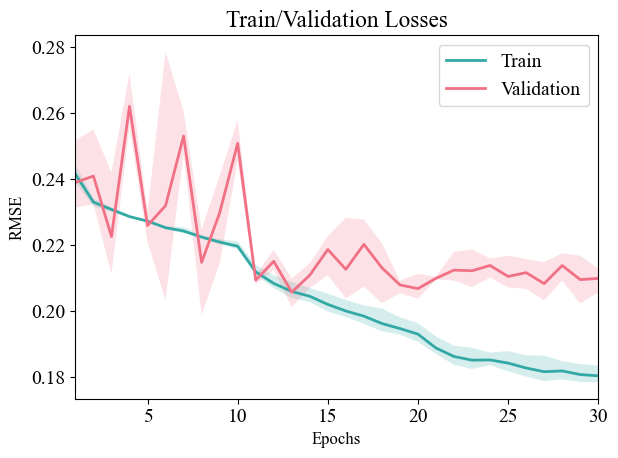

In [18]:
plot_train_test_losses(train_arr,val_arr, title="Train/Validation Losses", x_label="Epochs", y_label="RMSE",
                       min_max_bounds= True, tight_x_lim= True,
                       train_legend = "Train", test_legend = "Validation",
                       save_path=f"results/RUN_{run_name}_{USER}.png")

In [19]:
import csv

In [20]:
# Format the date and time
now = datetime.now()
finish_string = now.strftime("%Y-%m-%d %H:%M:%S")
print("Current Date and Time:", finish_string)

Current Date and Time: 2023-06-05 13:01:48


In [21]:
cv_results["MAE"],cv_results['RMSE'],cv_results["R2"]

([0.16686533147096633, 0.16963046967983245, 0.16595222795009612],
 [0.20767861533164977, 0.21158879053592683, 0.2114109605550766],
 [-0.6325224542617798, -0.5969783787727356, -0.5607270040512085])

In [22]:
cv_results_full = {}
cv_results_full['MAE_MEAN'] = np.mean(cv_results['MAE'])
cv_results_full['RMSE_MEAN'] = np.mean(cv_results['RMSE'])
cv_results_full['R2_MEAN'] = np.mean(cv_results['R2'])
cv_results_full['MAE_MEAN'],cv_results_full['RMSE_MEAN'],cv_results_full['R2_MEAN']

(0.16748267636696498, 0.2102261221408844, -0.596742612361908)

In [23]:
cv_results_full['USE_LSTM_BRANCH'] = USE_LSTM_BRANCH
cv_results_full['NUM_CLIMATE_FEATURES'] = NUM_CLIMATE_FEATURES if USE_LSTM_BRANCH else None
cv_results_full['CSV_FILES'] = CSV_FILES if USE_LSTM_BRANCH else None
cv_results_full['NUM_WORKERS'] = NUM_WORKERS
cv_results_full['TRAIN_BATCH_SIZE'] = TRAIN_BATCH_SIZE
cv_results_full['TEST_BATCH_SIZE'] = TEST_BATCH_SIZE
cv_results_full['LEARNING_RATE'] = LEARNING_RATE
cv_results_full['NUM_EPOCHS'] = NUM_EPOCHS
cv_results_full['LR_SCHEDULER'] = LR_SCHEDULER
cv_results_full['RESNET_VERSION'] = RESNET_VERSION
cv_results_full['REG_VERSION'] = REG_VERSION
cv_results_full['USE_SPATIAL_ATTENTION'] = USE_SPATIAL_ATTENTION
cv_results_full['Best Seed'] = best_seed
cv_results_full['SEEDS'] = SEEDS
cv_results_full['OC_MAX'] = OC_MAX
cv_results_full['USE_SRTM'] = USE_SRTM
cv_results_full['TIME'] = {"start": start_string, "finish": finish_string}
cv_results_full['cv_results'] = cv_results

In [24]:
with open(f"results/RUN_{run_name}_{USER}.json", "w") as fp:
    json.dump(cv_results_full, fp, indent=4)

In [25]:
# READ JSON FILE
# with open("results/my_dict.json", "r") as fp:
#     my_dict = json.load(fp)

# print(my_dict)

# Analysis

## Save Outputs

### Loading the Best Model
Loading the best model from all the coross validation runs.

In [26]:
load_checkpoint(model=model, optimizer=torch.optim.Adam(model.parameters(), lr=LEARNING_RATE),filename=f"results/RUN_{run_name}_{USER}.pth.tar")
model.eval()
print("Model loaded")

Loading checkpoint=> Done!
Model loaded


In [27]:
test_dl_w_id = DataLoader(testval_ds_w_id, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [28]:
test_step_w_id(model=model, data_loader=test_dl_w_id, loss_fn=nn.L1Loss(), verbose=False, csv_file=f"results/RUN_{run_name}_{USER}.csv")

## Visualize Spatial Attention

In [29]:
if not USE_SPATIAL_ATTENTION or USE_LSTM_BRANCH:
    raise Exception("The Next Part of the Notebook is only available for the model with Spatial Attention and no LSTM Branch")

In [30]:
BATCH_N = 1
IMG_IN_BATCH = 2

In [31]:
batch_loader = BatchLoader(test_dl_w_id)

In [32]:
batch = batch_loader(BATCH_N)
batch[0].shape, batch[1].shape, len(batch[2])

(torch.Size([32, 14, 64, 64]), torch.Size([32]), 32)

In [33]:
import sys
import importlib
importlib.reload(sys.modules['plot_utils'])

<module 'plot_utils' from 'c:\\Users\\nkakhani\\_Multimodal\\SoilNet-5\\SoilNet\\plot_utils\\__init__.py'>

In [34]:
from plot_utils.plot import *
from PIL import Image

In [35]:
# check if results/attention_maps folder exists if not create it
if not os.path.exists("results/attention_maps"):
    os.makedirs("results/attention_maps")

Point Id: 27461878
torch.Size([32, 1])
torch.Size([32, 1, 8, 8])


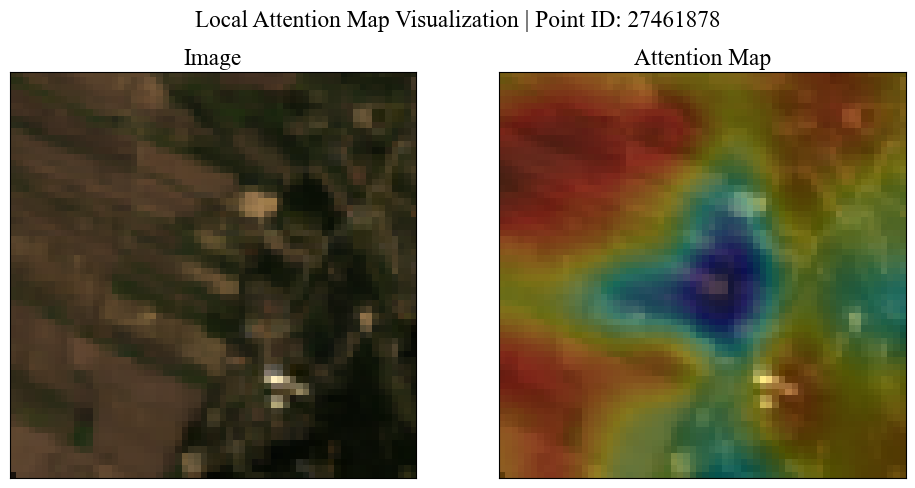

In [36]:
ABS_ATT = False
ALPHA = 0.3
with torch.no_grad():
    pid = batch[2][IMG_IN_BATCH]
    print("Point Id:", pid)
    out = model(batch[0].to(device))
    print(out.shape)
    print(model.cnn.glam.local_spatial_att.att_map.shape)
    img_rgb = batch[0][0].permute(1,2,0)[:,:,[3,2,1]].detach().cpu().numpy()
    img_rgb = convert2uint8(normalize(img_rgb))
    
    att_map = model.cnn.glam.local_spatial_att.att_map
    att_map = F.interpolate(att_map, size=(64, 64), mode='bicubic', align_corners=True)[IMG_IN_BATCH].detach().cpu().numpy()[0]
    att_map = np.abs(att_map) if ABS_ATT else att_map
    att_map = convert2uint8(normalize(att_map))   
    
    colormap = cv2.applyColorMap(att_map, cv2.COLORMAP_JET)
    
    img_colormaped = cv2.addWeighted(img_rgb, 1 - ALPHA, colormap, ALPHA, 0)

    display_images(img_rgb, img_colormaped, ["Image", "Attention Map"], f"Local Attention Map Visualization | Point ID: {pid}", figsize=(10,5), savepath=f"results/attention_maps/RUN_{run_name}_{USER}_pid{pid}_lcl.png")
    
    # Save img_rgband img_colormaped as jpg files
    cv2.imwrite(f"results/attention_maps/RUN_{run_name}_{USER}_pid{pid}_img_lcl_rgb.png", cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))
    cv2.imwrite(f"results/attention_maps/RUN_{run_name}_{USER}_pid{pid}_img_lcl_colormaped.png", cv2.cvtColor(img_colormaped, cv2.COLOR_RGB2BGR))
    
    
    

Point Id: 27461878
torch.Size([32, 1])
torch.Size([32, 512, 8, 8])


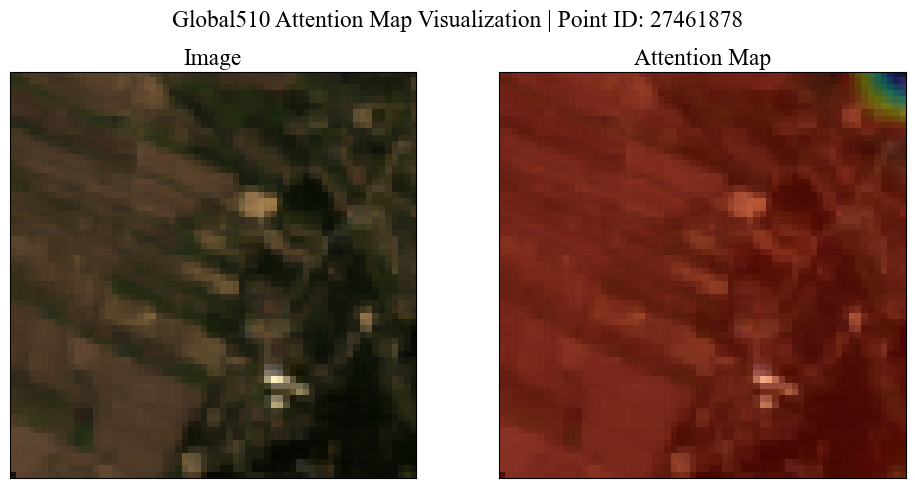

In [37]:
GLOB_ATT_CHANNEL = 510 # ranges between 0 and 511
with torch.no_grad():
    pid = batch[2][IMG_IN_BATCH]
    print("Point Id:", pid)
    out = model(batch[0].to(device))
    print(out.shape)
    print(model.cnn.glam.global_spatial_att.att.shape)
    img_rgb = batch[0][0].permute(1,2,0)[:,:,[3,2,1]].detach().cpu().numpy()
    img_rgb = convert2uint8(normalize(img_rgb))
    
    att_map = model.cnn.glam.global_spatial_att.att
    att_map = F.interpolate(att_map, size=(64, 64), mode='bicubic', align_corners=True)[IMG_IN_BATCH].detach().cpu().numpy()[GLOB_ATT_CHANNEL]
    att_map = np.abs(att_map) if ABS_ATT else att_map
    att_map = convert2uint8(normalize(att_map))   
    
    colormap = cv2.applyColorMap(att_map, cv2.COLORMAP_JET)
    
    img_colormaped = cv2.addWeighted(img_rgb, 1 - ALPHA, colormap, ALPHA, 0)

    display_images(img_rgb, img_colormaped, ["Image", "Attention Map"], f"Global{GLOB_ATT_CHANNEL} Attention Map Visualization | Point ID: {pid}", figsize=(10,5), savepath=f"results/attention_maps/RUN_{run_name}_{USER}_pid{pid}_glb{GLOB_ATT_CHANNEL}.png")
    
    # Save img_rgband img_colormaped as jpg files
    cv2.imwrite(f"results/attention_maps/RUN_{run_name}_{USER}_pid{pid}_img_glb{GLOB_ATT_CHANNEL}_rgb.png", cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))
    cv2.imwrite(f"results/attention_maps/RUN_{run_name}_{USER}_pid{pid}_img_glb{GLOB_ATT_CHANNEL}_colormaped.png", cv2.cvtColor(img_colormaped, cv2.COLOR_RGB2BGR))
    
    
    